<a href="https://colab.research.google.com/github/koralturkk/QuoraQuestionPairs/blob/master/QuoraQuestionPairs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quora Question Pairs

Quora Question Pairs challenge is a semantic similarity problem. In the notebook, I have followed word and sentence embeddings to vectorize words and sentences to extract patterns and find out degrees of similarity between sentences.

The following notebook is consisted of parts listed below to approach the problem. 



1.   Explanatory Data Analysis


          *   Stratified Sampling
          *   Train/Val/Test Split




2.   Models for Semantic Similarity


          2.1. Sentence Embeddings

              *   Google's Universal Sentence Encoder
              *   Sentence-BERT 


          2.2. Word Embeddings

              *   Google News's Word2Vec and Siamese Network

3. Overview and Conclusion


In the notebook, pre-trained embedding layers are used to vectorize words and sentences. Transfer Learning in NLP tasks are widely used approach when the computational and data resources are scarce. The embedding models are generated by training process of state of the art models on very large text corpus. 

#### Link to drive and import custom packages

The 

In [0]:
from google.colab import drive
import sys

drive.mount('/content/drive')
sys.path.append('/content/drive/My Drive/Colab Notebooks')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


#### Loading Packages

In [0]:
import tensorflow as tf
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow_hub as hub
import seaborn as sns
import os, re, io, random
from absl import logging
from google.colab import files
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score 
from sentence_transformers import SentenceTransformer
import scipy.spatial
import json
import torch ## loading file
from google.colab import drive
import nltk ## stopwords
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding,Activation,Flatten,merge,TimeDistributed,CuDNNGRU,Bidirectional
from keras.layers.merge import concatenate
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import concatenate,subtract,add,maximum,multiply,Layer,Lambda
from keras.backend import backend as K
from tqdm import tqdm
from keras.preprocessing.sequence import pad_sequences
from gensim.models import KeyedVectors
import itertools
from hyperopt import Trials, STATUS_OK, tpe, fmin, hp
from keras import optimizers
import pickle

Using TensorFlow backend.


"nltk" package will provide a list of stop words that will be useful when cleaning the text.  

In [0]:
stop_words = nltk.download('stopwords')
stop_words = stopwords.words("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Saving and Loading Files

Due to the storage heavy nature of embeddings and models, it is a good practice to store processesed embeddings and models to avoid overhead. 

In [0]:
def save_obj(obj, name):
    with open("/content/drive/My Drive/"+ name + ".pkl", "wb") as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open("/content/drive/My Drive/"+ name + ".pkl", "rb") as f:
        return pickle.load(f)

#save = save_obj(embedding_dict, "embeddings")

#embedding_dict = {}

model_save_name = 'embeddings.pt'
path = F"/content/drive/My Drive/{model_save_name}" 

def add_to_embedding_dict(key:str, value):
  embedding_dict.update({key:value})

## To save a file
#torch.save(embedding_dict, path)
#save_obj(embedding_dict,'embeddings')


## To load a file 
#embedding_dict = torch.load(path)

embedding_dict = load_obj("embeddings")


In [0]:
train_data = pd.read_csv("/content/drive/My Drive/Datasets/train.csv")
#test_data = pd.read_csv(io.BytesIO(uploaded['test.csv']))

## Exploratory Data Analysis 

Make a statement about length of sentences and their contribution to performance

### Preprocessing 

#### Handling Missing Values

In [0]:
print("Missing Values in question1 column: {}".format(train_data["question1"].isnull().sum()))
print("Missing Values in question2 column: {}".format(train_data["question2"].isnull().sum()))

Missing Values in question1 column: 1
Missing Values in question2 column: 2


#### Removing Rows with Missing Values

In [0]:
train_data = train_data.dropna(how='any',axis=0) 

In [0]:
print("Missing Values in question1 column: {}".format(train_data["question1"].isnull().sum()))
print("Missing Values in question2 column: {}".format(train_data["question2"].isnull().sum()))

Missing Values in question1 column: 0
Missing Values in question2 column: 0


#### Cleaning Text

In [0]:
def clean_columns(df, columns = [], clean_stop_words = False):

  for col in columns:
    df.loc[:,col] = df.loc[:,col].apply(lambda x: " ".join(x.lower() for x in x.split()))
    df.loc[:,col] = df.loc[:,col].str.replace(r"\d+", "")
    df.loc[:,col] = df.loc[:,col].str.replace('[^\w\s]','')
    df.loc[:,col] = df.loc[:,col].str.replace(r"[︰-＠]", "")

    if clean_stop_words:
      df.loc[:,col] = df.loc[:,col].apply(lambda x: " ".join(x for x in x.split() if x not in stop_words)) ##stop words

  return df

In [0]:
print(train_data.tail())
print(train_data.head())

            id  ...  is_duplicate
404285  404285  ...             0
404286  404286  ...             1
404287  404287  ...             0
404288  404288  ...             0
404289  404289  ...             0

[5 rows x 6 columns]
   id  qid1  ...                                          question2 is_duplicate
0   0     1  ...  What is the step by step guide to invest in sh...            0
1   1     3  ...  What would happen if the Indian government sto...            0
2   2     5  ...  How can Internet speed be increased by hacking...            0
3   3     7  ...  Find the remainder when [math]23^{24}[/math] i...            0
4   4     9  ...            Which fish would survive in salt water?            0

[5 rows x 6 columns]


In [0]:
train_data = clean_columns(train_data, ["question1", "question2"])
print(train_data.tail())
print(train_data.head())

            id  ...  is_duplicate
404285  404285  ...             0
404286  404286  ...             1
404287  404287  ...             0
404288  404288  ...             0
404289  404289  ...             0

[5 rows x 6 columns]
   id  qid1  ...                                          question2 is_duplicate
0   0     1  ...  what is the step by step guide to invest in sh...            0
1   1     3  ...  what would happen if the indian government sto...            0
2   2     5  ...  how can internet speed be increased by hacking...            0
3   3     7  ...    find the remainder when mathmath is divided by             0
4   4     9  ...             which fish would survive in salt water            0

[5 rows x 6 columns]


### Sampling Training Set

Since the data set is too large. I will work on sample data to build NLP model to make to training and optimization process more robust. It is important to preserve the distribution to build a viable model for deployment.

Therefore, I will used stratified sampling to sample data that has same distribution of "is_duplicate" labels from the dataset. 

In [0]:
y = train_data["is_duplicate"]
X = train_data.copy(deep=False).drop(columns = ["is_duplicate"])

X_source, X_sample, y_source, y_sample = train_test_split(X, y, test_size=0.1, random_state=42, stratify= y)

In [0]:
y_sample.value_counts()

0    25503
1    14926
Name: is_duplicate, dtype: int64

In [0]:
print("Sample distribution of label 1: ",y_sample.value_counts()[1]/y_sample.value_counts().sum())

Sample distribution of label 1:  0.369190432610255


In [0]:
train_data.is_duplicate.value_counts()

0    255024
1    149263
Name: is_duplicate, dtype: int64

In [0]:
print("Source data distribution of label 1: ", train_data.is_duplicate.value_counts()[1]/train_data.is_duplicate.value_counts().sum())

Source data distribution of label 1:  0.3692005926482919


The distribution of labels are very close to each other. We can move forward with the implementation on sample data. 

### Train/Val/Test Set

Seperation of data into train/val/test set help us to validate the generalizability of models. 

The model is trained on training data, tuned on val data and final test is to check results on test data to see how valid the model is on unseen examples. 

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.2, random_state=42, stratify = y_sample)

In [0]:
X_train.reset_index(inplace=True)
X_test.reset_index(inplace=True)
#y_train.reset_index(inplace=True)
#y_test.reset_index(inplace=True)

# Models for Semantic Similarity

Models for semantic similarity use embeddings to vectorize sentences or words. Then various distance metrics are calculated to measure variations between vector outputs. Some of the most commonly used distance metrics are Cosine Similarity, Manhattan Distance, Minkowski Distance and Euclidean Distance. 

#### Distance Metrics 

Distance metrics help us identify the relative difference or similarity between different vectors. Which distance metrics to be used relies on the nature of the problem. Moreover, distance metrics that are suitable for the problem scope can be accepted as a hyperparameter, therefore, they can be subjected comparison by the f1 score they yield. 

#### Useful Functions

In [0]:
def report_predictions(y_train, predictions):
  actual = y_train.to_list()
  results = confusion_matrix(actual, predictions) 
  print('Confusion Matrix :')
  print(results) 
  print('Accuracy Score :',accuracy_score(actual, predictions))
  print('Report : ')
  print(classification_report(actual, predictions))

def cosine_similarities(embedding_1, embedding_2):
  if len(embedding_1) == len(embedding_2):
    length = len(embedding_1)
  else:
    return print("Array sizes do not match")

  similarities = []

  for i in range(length):
    sentence_1 = np.reshape(embedding_1[i], (1, -1))
    sentence_2 = np.reshape(embedding_2[i], (1, -1))
    similarity = float(cosine_similarity(sentence_1,sentence_2))
    similarities.append(similarity)

  return np.reshape(similarities, (-1,1))

def get_predictions(similarities, threshold = 0.8):
  predictions = list(map(float, similarities>threshold))
  return predictions

def find_max_word_count(df, columns):
  count = 0
  for col in columns:
    new_count = max(df[col].str.split().map(len))
    if new_count > count:
      count = new_count

    else:
      continue
  return count


def tokenize(df, questions_cols):
 
  for index, row in df.iterrows():

      for question in questions_cols:

          q2n = [] 
          for word in row[question].split():
              if word in stop_words and word not in word2vec.vocab:
                  continue

              if word not in vocabulary:
                  vocabulary[word] = len(inverse_vocabulary)
                  q2n.append(len(inverse_vocabulary))
                  inverse_vocabulary.append(word)
              else:
                  q2n.append(vocabulary[word])

          df.set_value(index, question, q2n)

  return df

def build_embedding_matrix(vocabulary, embedding_dim =300):
  embeddings = 1 * np.random.randn(len(vocabulary) + 1, embedding_dim)  # This will be the embedding matrix
  embeddings[0] = 0  # So that the padding will be ignored

# Build the embedding matrix
  for word, index in vocabulary.items():
    if word in word2vec.vocab:
      embeddings[index] = word2vec.word_vec(word)

  return embeddings 

## Sentence Embedding Models

Sentence Embedding Models embeds full sentences into a vector representation. On this task I will implement and assess results of Universal Sentence Encoder and Sentence-Bert.


*   Google's Universal Sentence Encoder

        1.   Deep Averaging Network
        2.   Transformer


*   Sentence-Bert 



Paper 
Take a look!!   
-https://arxiv.org/pdf/1907.04307.pdf  
-https://www.learnopencv.com/universal-sentence-encoder/


### Universal Sentence Encoder

There are 2 embeddings shared with the community in Universal Sentence Encoder. Both trained with different architectures, Deep Averaging Networks and Transformer Networks. These architectures present trade-offs, DAN model is computationally less expensive and has less accuracy overall while the model with transformer encoder scores higher accuracy with more computational costs. 

I will try to implement both for the project to see their impact on predictions. 

#### Universal Sentence Encoder Trained with Deep Averaging Network

In [0]:
#DAN_module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" #@param ["https://tfhub.dev/google/universal-sentence-encoder/4"]

# Reduce logging output.
#logging.set_verbosity(logging.ERROR)

#DAN_module_embedding = hub.KerasLayer(DAN_module_url)

In [0]:
##Create

#question_1_list = X_train.loc[:,"question1"].to_list()
#question_2_list = X_train.loc[:,"question2"].to_list()


#with tf.Session() as session:
 # session.run([tf.global_variables_initializer(), tf.tables_initializer()])
  #question_1_DAN_embeddings = session.run(DAN_module_embedding(question_1_list))
  #question_2_DAN_embeddings = session.run(DAN_module_embedding(question_2_list))

## Load
question_1_DAN_embeddings, question_2_DAN_embeddings = embedding_dict["question_1_DAN_embeddings"], embedding_dict["question_2_DAN_embeddings"]

In [0]:
DAN_similarities = cosine_similarities(question_1_DAN_embeddings,question_2_DAN_embeddings)
DAN_predictions = get_predictions(DAN_similarities, 0.8)

In [76]:
DAN_report = report_predictions(y_train, DAN_predictions)
DAN_report

Confusion Matrix :
[[15809  4593]
 [ 4214  7727]]
Accuracy Score : 0.7276999659895496
Report : 
              precision    recall  f1-score   support

           0       0.79      0.77      0.78     20402
           1       0.63      0.65      0.64     11941

    accuracy                           0.73     32343
   macro avg       0.71      0.71      0.71     32343
weighted avg       0.73      0.73      0.73     32343



In [0]:
### Save
add_to_embedding_dict("question_1_DAN_embeddings",question_1_DAN_embeddings)
add_to_embedding_dict("question_2_DAN_embeddings",question_2_DAN_embeddings)
#torch.save(embedding_dict, path)

#### Universal Sentence Encoder with Transformer Encoder

Crashed due to RAM

In [0]:
#TRANS_module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/5" #@param ["https://tfhub.dev/google/universal-sentence-encoder-large/5"]
#TRANS_module_embedding = hub.load(TRANS_module_url)

In [0]:
#with tf.Session() as session:
 # session.run([tf.global_variables_initializer(), tf.tables_initializer()])
  #question_1_TRANS_embeddings, question_2_TRANS_embeddings = session.run([TRANS_module_embedding(question_1_list), TRANS_module_embedding(question_2_list)])

In [0]:
#TRANS_similarities = cosine_similarities(question_1_TRANS_embeddings,question_2_TRANS_embeddings)
#TRANS_predictions = get_predictions(similarities, 0.8)

In [0]:
#report_predictions(y_train, TRANS_predictions)

### Sentence-BERT


Researchers in Ubiquitous Knowledge Processing Labb (UKP-TUDA) implemented Sentence-Bert model which is a modification of a pretrained BERT network. The model uses siamese and triplet network to derive semantically meaningful sentence embeddings. This way, they have utilized BERT to be used for new tasks such as semantic similarity which was not possible before.


In [0]:
### Encoding Text into Sentence Embeddings

bert_nli_stsb_mean_transformer = SentenceTransformer('bert-base-nli-stsb-mean-tokens')
bert_nli_stsb_mean_question_1_embeddings = bert_nli_stsb_mean_transformer.encode(question_1_list)
bert_nli_stsb_mean_question_2_embeddings = bert_nli_stsb_mean_transformer.encode(question_2_list)

### Loading pre-encoded sentence embeddings

#bert_nli_stsb_mean_question_1_embeddings = embedding_dict["bert_nli_stsb_mean_question_1_embeddings"]
#bert_nli_stsb_mean_question_2_embeddings = embedding_dict["bert_nli_stsb_mean_question_2_embeddings"]

100%|██████████| 405M/405M [00:05<00:00, 71.9MB/s]


In [0]:
## To save a file


#add_to_embedding_dict("bert_nli_stsb_mean_question_1_embeddings",bert_nli_stsb_mean_question_1_embeddings)
#add_to_embedding_dict("bert_nli_stsb_mean_question_2_embeddings", bert_nli_stsb_mean_question_2_embeddings)


#save_obj(embedding_dict,"embeddings")

#torch.save(embedding_dict, path)

In [0]:
sbert_similarities = cosine_similarities(bert_nli_stsb_mean_question_1_embeddings,bert_nli_stsb_mean_question_2_embeddings)
sbert_predictions = get_predictions(sbert_similarities, 0.8)

In [0]:
sbert_report = report_predictions(y_train, sbert_predictions)
sbert_report

Confusion Matrix :
[[16234  4168]
 [ 4578  7363]]
Accuracy Score : 0.7295860000618372
Report : 
              precision    recall  f1-score   support

           0       0.78      0.80      0.79     20402
           1       0.64      0.62      0.63     11941

    accuracy                           0.73     32343
   macro avg       0.71      0.71      0.71     32343
weighted avg       0.73      0.73      0.73     32343



In [0]:
#del bert_nli_stsb_mean_transformer

## Word Embedding Models

https://github.com/eliorc/Medium/blob/master/MaLSTM.ipynb

In the word embedding models, in order to have achieve a "is duplicate" binary classification objective, we need to feed word embedding sequences to a siamese network. Then, the encoded sequence will decide how much semantically similar these two input sequences by calculating the cosine similarity between two outputs of the network. 


The choice of word embedding to vectorize words is important for performance. Therefore, I would choose to work with Google News' word2vec embeddings. 

The selection of word embeddings has to be done empirically. Each trial has to be documented and we should deploy model that yield highest accuracy and f1 score. 

In [83]:
## max word count is needed to implement sequences. So that we can instantiate sequences that can encapsulate all the sentence in the dataset. 
max_word_count = find_max_word_count(train_data,["question1", "question2"])
print(max_word_count)

234


#### Word2Vec

After the creation of embedding matrix for the word that we have, it is not necessary to load the GoogleNews Embedding File due to its size

In [0]:
#word2vec_embedding_file = "/content/drive/My Drive/GoogleNews-vectors-negative300.bin.gz"
#word2vec = KeyedVectors.load_word2vec_format(word2vec_embedding_file, binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


#### Word Embedding Matrix

In [0]:
vocabulary = dict()
inverse_vocabulary = ['<unk>']  # '<unk>' will never be used, it is only a placeholder for the [0, 0, ....0] embedding
questions_cols = ['question1', 'question2']

## Tokenize questions 

X_w2v = clean_columns(X_sample.copy(deep=False), columns = questions_cols, clean_stop_words = True)
X_w2v = tokenize(X_w2v,questions_cols)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


In [0]:
## Embedding 
word_2_vec_embeddings = embedding_dict["word_2_vec_embeddings"]   #build_embedding_matrix(vocabulary,embedding_dim =300) 

## Delete 
#del word2vec

#add_to_embedding_dict("word_2_vec_embeddings",word_2_vec_embeddings)

#save_obj(embedding_dict,"embeddings")

In [0]:
X_w2v.head()

,id,qid1,qid2,question1,question2
156326,156326,244682,244683,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]","[12, 1, 2, 13, 9, 14, 15, 10, 16, 17, 18, 19]"
233222,233222,343427,343428,"[20, 21, 22, 23, 24]","[25, 21, 26, 27, 28]"
318647,318647,444025,444026,"[29, 30, 31]","[29, 30, 31]"
401836,401836,535283,535284,"[32, 33, 34]","[32, 33]"
3053,3053,6053,6054,"[35, 36]","[35, 36]"


### Splitting Data

In [0]:
X_train_w2v, X_val_w2v, y_train_w2v, y_val_w2v = train_test_split(X_w2v, y_sample, test_size=0.2, random_state=42, stratify = y_sample)

In [0]:
### Changing X_train_w2v to dict will provide greater ease at siamese network

X_train_w2v = {'left': X_train_w2v.question1, 'right': X_train_w2v.question2}
X_val_w2v = {'left': X_val_w2v.question1, 'right': X_val_w2v.question2}

# Convert labels to their numpy representations
y_train_w2v = y_train_w2v.values
y_val_w2v = y_val_w2v.values

# Zero padding
for dataset, side in itertools.product([X_train_w2v, X_val_w2v], ['left', 'right']):
    dataset[side] = pad_sequences(dataset[side], maxlen=max_word_count)

# Make sure everything is ok
assert X_train_w2v['left'].shape == X_train_w2v['right'].shape
assert len(X_train_w2v['left']) == len(y_train_w2v)

In [0]:
### Model Implementation

# Model variables
embedding_dim = 300
n_hidden = 50
gradient_clipping_norm = 1.25
batch_size = 64
n_epoch = 25

from keras.layers import Input, Embedding, LSTM, Lambda, Bidirectional
import keras.backend as K
from keras.optimizers import Adadelta, SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
import time

def cosine_distance(x1, x2):
    x1 = K.l2_normalize(x1, axis=-1)
    x2 = K.l2_normalize(x2, axis=-1)
    return -K.mean(x1 * x2, axis=-1, keepdims=True)

def cos_dist_output_shape(shape_1, shape_2):
    shape1, shape2 = shapes
    return (shape1[0],1)

def exponent_neg_manhattan_distance(left, right):
    ''' Helper function for the similarity estimate of the LSTMs outputs'''
    return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))


# The visible layer
left_input = Input(shape=(max_word_count,), dtype='int32')
right_input = Input(shape=(max_word_count,), dtype='int32')

embedding_layer = Embedding(len(word_2_vec_embeddings), embedding_dim, weights=[word_2_vec_embeddings], input_length=max_word_count, trainable=False)

# Embedded version of the inputs
encoded_left = embedding_layer(left_input)
encoded_right = embedding_layer(right_input)

# Since this is a siamese network, both sides share the same LSTM
shared_lstm = Bidirectional(LSTM(n_hidden))

left_output = shared_lstm(encoded_left)
right_output = shared_lstm(encoded_right)


# Calculates the distance as defined by the MaLSTM model
malstm_distance = Lambda(function=lambda x: exponent_neg_manhattan_distance(x[0], x[1]),output_shape=lambda x: (x[0][0], 1))([left_output, right_output])

# Pack it all up into a model
malstm = Model([left_input, right_input], [malstm_distance])

# Adadelta optimizer, with gradient clipping by norm
optimizer = Adadelta(clipnorm=gradient_clipping_norm)


## Callbacks

## Learning Rate 

#lr_schedule = LearningRateScheduler(lambda epoch: 1e-8*10**(epoch/5))

## Checkpoint Callback
filepath="/content/drive/My Drive/weights.best.hdf5"
model_checkpoint = ModelCheckpoint(filepath, monitor="val_acc", verbose=1, save_best_only=True, mode='max')
callbacks_list = [model_checkpoint]

# load weights
#malstm = malstm.load_weights("/content/drive/My Drive/weights.best.hdf5")

malstm.compile(loss="mean_squared_error", optimizer=optimizer, metrics=["accuracy"])

# Start training

malstm_trained = malstm.fit([X_train_w2v['left'], X_train_w2v['right']], y_train_w2v, batch_size=batch_size, epochs=n_epoch,
                            validation_data=([X_val_w2v['left'], X_val_w2v['right']], y_val_w2v),callbacks=callbacks_list, verbose = 1)



Train on 32343 samples, validate on 8086 samples
Epoch 1/25
32343/32343 [==============================] - 766s 24ms/step - loss: 0.2102 - acc: 0.6919 - val_loss: 0.1929 - val_acc: 0.7216

Epoch 00001: val_acc improved from -inf to 0.72162, saving model to /content/drive/My Drive/weights.best.hdf5
Epoch 2/25
13120/32343 [===========>..................] - ETA: 6:51 - loss: 0.1899 - acc: 0.7245

[1e-08, 0.0001, 0, 60]

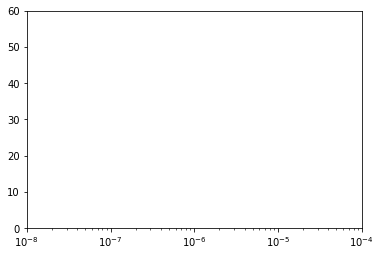

In [0]:
learning_rate_plot = plt.semilogx(malstm_trained.history["lr"], malstm_trained.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

## Hyperparameter optimization

https://public.ukp.informatik.tu-darmstadt.de/reimers/Optimal_Hyperparameters_for_Deep_LSTM-Networks.pdf

https://towardsdatascience.com/finding-the-right-architecture-for-neural-network-b0439efa4587

Hyperparameters

Recurrent Unit = [25,50,75,100]
Batch_Size =  1, 8, 16, 32, and 64
Learning Rate 
Distance Function 

---- Optimizer ---  
Adam and Adam with Nesterov momentum
(Nadam) usually performed the best, followed
by RMSProp. Adadelta and Adagrad had a
much higher variance in terms of test performance and resulted on average to far worse
results. SGD failed in a high number of cases
to converge to a minimum, likely due to its
high sensitivity of the learning rate. Nadam
was the fastest optimizer. 


Model Implementation => (Article) Siamese Recurrent Architectures for Learning Sentence Similarity


Distance Metrics 
  
-https://towardsdatascience.com/importance-of-distance-metrics-in-machine-learning-modelling-e51395ffe60d

In [0]:
from hyperopt import Trials, STATUS_OK, tpe, fmin, hp
from keras import optimizers

search_space = {
    'batch_size': hp.choice('bs', [8,16,32,64,128]),
    'lstm1_nodes': hp.choice('units_lsmt1', [25,50,75,100]),
    "lr": hp.uniform('lr',0,1),
    "epochs": hp.choice('epochs', [30, 40, 50, 60, 70]),
    "optimizer": hp.choice('optmz',["sgd", "rms","adamdelta"]),
    "distance_metric": hp.choice('dist',["exponent_neg_manhattan_distance", "cosine_distance"]),
    "loss": hp.choice('loss',["huber_loss", "mean_squeared_error"]),
}


def build_siamese_network(params):

  
  left_input = Input(shape=(max_word_count,), dtype='int32')
  right_input = Input(shape=(max_word_count,), dtype='int32')

  embedding_layer = Embedding(len(word_2_vec_embeddings), embedding_dim, weights=[word_2_vec_embeddings], input_length=max_word_count, trainable=False)

  encoded_left = embedding_layer(left_input)
  encoded_right = embedding_layer(right_input)

  shared_lstm = Bidirectional(LSTM(params["lstm1_nodes"]))   ##Bidirectional(LSTM(n_hidden))

  left_output = shared_lstm(encoded_left)
  right_output = shared_lstm(encoded_right)


  if params["distance_metric"] == "exponent_neg_manhattan_distance":
    distance = Lambda(function=lambda x: exponent_neg_manhattan_distance(x[0], x[1]),output_shape=lambda x: (x[0][0], 1))([left_output, right_output])
  if params["distance_metric"] == "cosine_distance":
    distance = Lambda(function=lambda x: cosine_distance(x[0], x[1]),output_shape=lambda x: (x[0][0], 1))([left_output, right_output])

  model = Model([left_input, right_input], [distance])

  ### Calbacks 
  file_name = 'siamese_callbacks.csv'
  callback_file = F"/content/drive/My Drive/{file_name}" 
  csv_callback = keras.callbacks.CSVLogger(callback_file, separator=',', append=False)


  lr = params["lr"]
  epochs = params["epochs"]
  batch_size = params["batch_size"]

  if params["optimizer"] == 'rms':
      optimizer = optimizers.RMSprop(lr=lr)
  elif params["optimizer"] == "adadelta":
      optimizer = Adadelta(clipnorm=gradient_clipping_norm)
  else:
      optimizer = optimizers.SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)


  model.compile(loss=params["loss"], optimizer=optimizer, metrics=['accuracy'])


  history = model.fit([X_train_w2v['left'], X_train_w2v['right']], y_train_w2v, batch_size=batch_size, epochs=epochs,
                            validation_data=([X_val_w2v['left'], X_val_w2v['right']], y_val_w2v),verbose=2,callbacks=[csv_callback])
  
  val_error = np.amin(model.history['val_loss']) 

  print('Best validation error of epoch:', val_error)
  return {'loss': val_error, 'status': STATUS_OK, 'model': lstm_model}

trials = Trials()
best = fmin(build_siamese_network,
    space=search_space,
    algo=tpe.suggest, # type random.suggest to select param values randomly
    max_evals=200, # max number of evaluations you want to do on objective function
    trials=trials)

Train on 32343 samples, validate on 8086 samples
Epoch 1/40
  0%|          | 0/200 [00:07<?, ?it/s, best loss: ?]


KeyboardInterrupt: ignored

## Citations 


*   Reimers, Nils, and Iryna Gurevych. “Sentence-BERT: Sentence Embeddings Using Siamese BERT-Networks.” Proceedings of the 2019 Conference on Empirical Methods in Natural Language Processing and the 9th International Joint Conference on Natural Language Processing (EMNLP-IJCNLP), 2019, doi:10.18653/v1/d19-1410.

*   Cer, Daniel & Yang, Yinfei & Kong, Sheng-yi & Hua, Nan & Limtiaco, Nicole & John, Rhomni & Constant, Noah & Guajardo-Cespedes, Mario & Yuan, Steve & Tar, Chris & Sung, Yun-Hsuan & Strope, Brian & Kurzweil, Ray. (2018). Universal Sentence Encoder. 

*   Neculoiu, Paul, et al. “Learning Text Similarity with Siamese Recurrent Networks.” Proceedings of the 1st Workshop on Representation Learning for NLP, 2016, doi:10.18653/v1/w16-1617.

